#### **Addition of LVIS based realistic noise in simulated full-waveforms Lidar data**  
**Author: Ramesh Bhatta, CIS, RIT**  
**Data: Simulated Full-Waveform data using DIRSIG (https://dirsig.cis.rit.edu/) tool.**

In [9]:
## Import Libraries

import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [10]:
## Predefined plot preferences

# Define text sizes
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

# Apply text size settings
plt.rc('font', size=SMALL_SIZE)          # Default font size
plt.rc('axes', titlesize=MEDIUM_SIZE)   # Axis title font size
plt.rc('axes', labelsize=MEDIUM_SIZE)   # Axis labels font size
plt.rc('xtick', labelsize=SMALL_SIZE)   # X-axis tick label font size
plt.rc('ytick', labelsize=SMALL_SIZE)   # Y-axis tick label font size
plt.rc('legend', fontsize=SMALL_SIZE)   # Legend font size
plt.rc('figure', titlesize=BIGGER_SIZE) # Figure title font size

#### **About the data- Each profile of the simulated data contains following columns:**   
0 - The bin number   
1 - The time-of-flight for the bin   
2 - The total number of photons (summed across all pixels) for the bin   
3 - The total number of photons (acrossed across all pixels) for the bin   
4 - The minimum number of photons (in any pixel) for the bin   
5 - The maximum number of photons (in any pixel) for the bin 

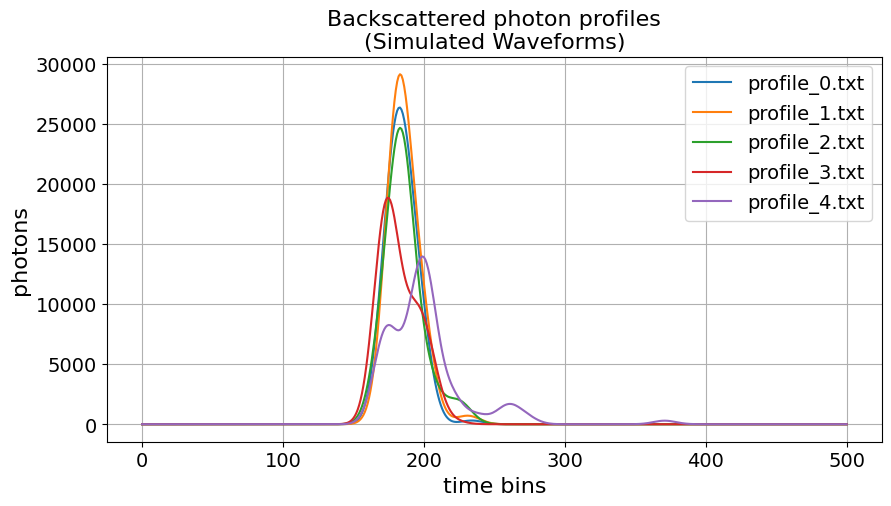

In [11]:
## 1. Sample visualization: read and plot the simulated return pulse profiles i.e. waveforms

# Define the path to the directory where your data is located
data_dir = './16ns_profiles'        ## The directory contains recorded waveforms corresponding to 16ns gaussian outgoing waveform
samples = 100

# Get a list of all files in the data directory that match the pattern "profile_*"
profiles = [f for f in os.listdir(data_dir) if os.path.isfile(os.path.join(data_dir, f)) and f.startswith('profile_') and f.endswith('.txt')]

# Sort the list of files based on the numerical part in their names
profiles.sort(key=lambda x: int(x.split('_')[1].split('.')[0]))
profiles = profiles[:samples]

# Generate the pulse profile plot
plt.figure(figsize=(10, 5))

for file in profiles[:5]:
    # Read the file into a pandas DataFrame
    df = pd.read_csv(os.path.join(data_dir, file), sep=" ", header=None)

    # Plot photon count profile
    plt.plot(df[0], df[2], label=file)

plt.legend()
plt.title(f'Backscattered photon profiles\n(Simulated Waveforms)')
plt.grid(which='both')
plt.xlabel('time bins')
plt.ylabel('photons')
plt.show()

#### **Optional Step: Converting Photon Count to Intensity/Power**

Given:

- **Wavelength** (λ)
- **Photon energy** (E<sub>photon</sub>): E<sub>photon</sub> = &harr; <sup>h &middot; c</sup> / λ
- **Time bin duration** (Δt)
- **Pixel size** (d)

The power detected per photon is:

$$
P_{\text{detected}} = \frac{N_{\text{photons}} \cdot E_{\text{photon}}}{\Delta t}
$$

The intensity is the power per unit area. Therefore, the intensity per photon is:

$$
I_{\text{1 photon}} = \frac{P_{\text{1 photon}}}{A_{\text{pixel}}} = \frac{\frac{E_{\text{photon}}}{\Delta t}}{A_{\text{pixel}}} = \frac{E_{\text{photon}}}{\Delta t \cdot A_{\text{pixel}}}
$$

The intensity for any photon count N<sub>photons</sub> is:

$$
I = N_{\text{photons}} \times \frac{E_{\text{photon}}}{\Delta t \cdot A_{\text{pixel}}}
$$


<Figure size 1000x500 with 0 Axes>

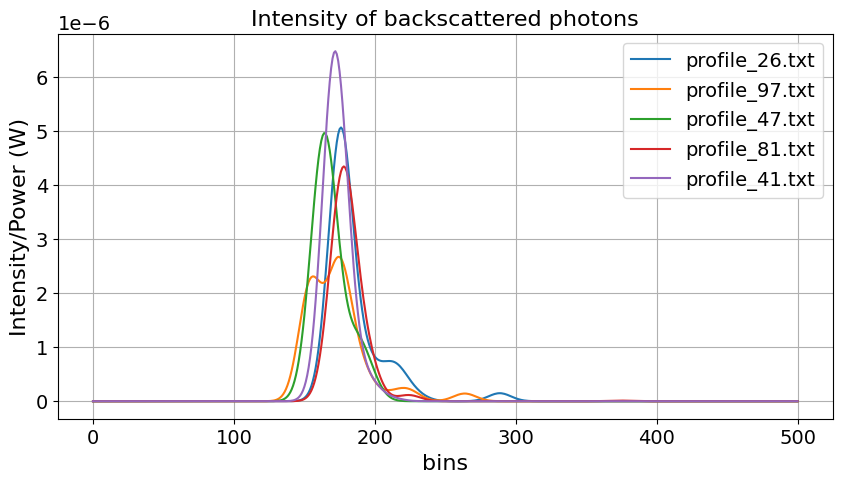

In [12]:
## Optional step: Conversion to time bins vs Intensity (power) plot

# Define constants

h = 6.62607015e-34  # Planck's constant in m^2 kg / s
c = 3e8  # Speed of light in m / s
lambda_ = 1064e-9  # Wavelength in meters
delta_t = 1e-9  # Sampling time in seconds
cf = h * c / (lambda_ * delta_t) # conversion factor

waveforms = {}

# Intensity profile plot

plt.figure(figsize=(10, 5))

for file in profiles:

    df = pd.read_csv(os.path.join(data_dir, file), sep=" ", header=None)
    new_df = pd.DataFrame()
    new_df['bins'] =  df[0]
    new_df['TOF'] = df[1] 
    new_df['intensity'] = df[2] * cf   # photon count to intensity
    waveforms[file] = new_df
    
# Select a few random samples from the dictionary
samples = random.sample(list(waveforms.keys()), 5)

# Generate the pulse profile plot
plt.figure(figsize=(10, 5))

for sample in samples:
    
    # Get the DataFrame for the sample
    df_sample = waveforms[sample]

    # Plot the intensity
    plt.plot(df_sample['bins'], df_sample['intensity'], label=sample)

plt.title('Intensity of backscattered photons')
plt.grid(which='both')
plt.xlabel('bins')
plt.ylabel('Intensity/Power (W)')
plt.legend()
plt.show()

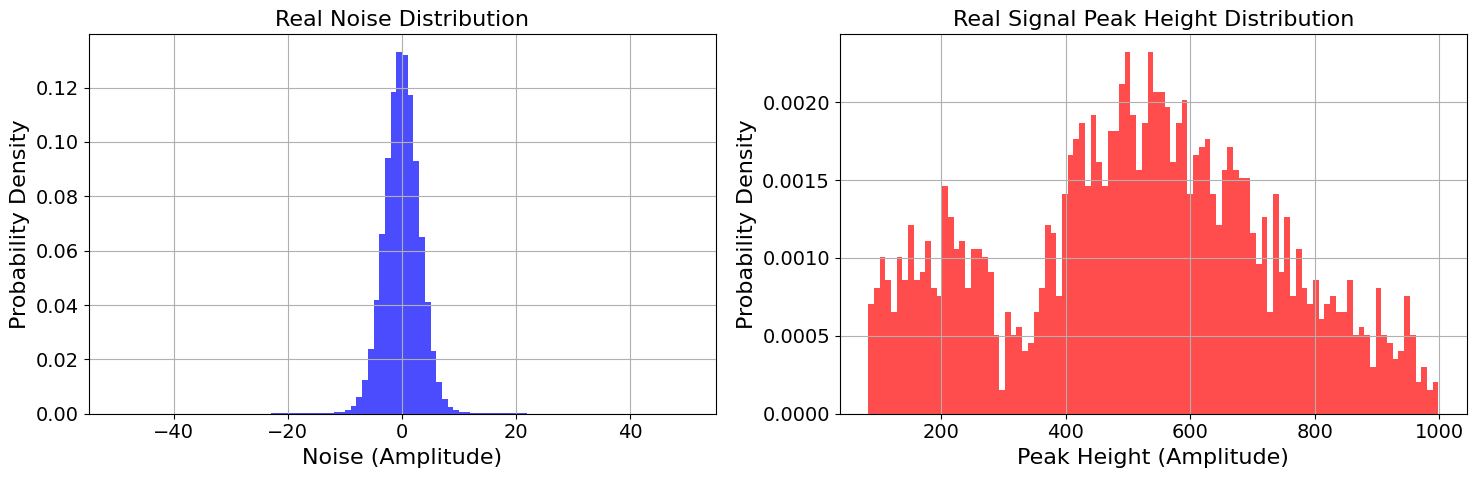

In [13]:
## 2. Read the signal strength and noise distribution that we obtained from noisy analysis of the real LVIS data

noise_real = np.loadtxt('./realdataBioscape_LVIS/lvis_noise_values.txt', skiprows =1)
signal_height_dist_real = np.loadtxt('./realdataBioscape_LVIS/lvis_peakHeight_values.txt', skiprows =1)

# Create the figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot the noise distribution on the first subplot
axs[0].hist(noise_real, bins=100, alpha=0.7, color='b', density=True)  # Normalize the histogram
axs[0].set_title('Real Noise Distribution')
axs[0].set_xlabel('Noise (Amplitude)')
axs[0].set_ylabel('Probability Density')
axs[0].grid(True)

# Plot the signal strength distribution on the second subplot
axs[1].hist(signal_height_dist_real, bins=100, alpha=0.7, color='r', density=True)  # Normalize the histogram
axs[1].set_title('Real Signal Peak Height Distribution')
axs[1].set_xlabel('Peak Height (Amplitude)')
axs[1].set_ylabel('Probability Density')
axs[1].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

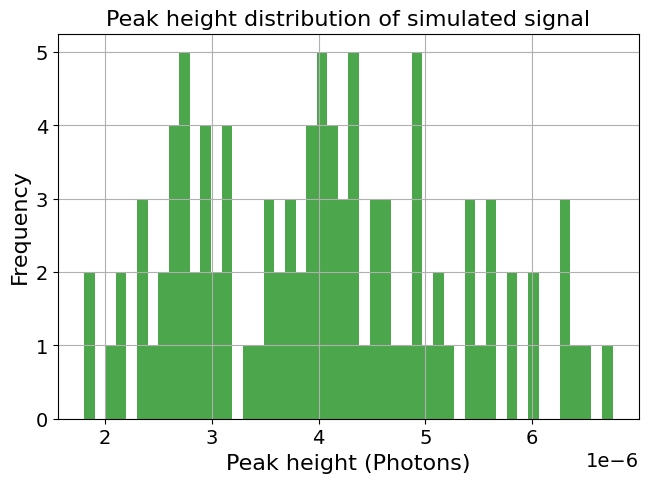

In [14]:
## 3. Determine the distribution of peak heights of our simulated signal profiles (waveforms)

# Initialize an empty list to store the signal strengths
signal_height_dist_sim = []

# Iterate over the waveforms in the dictionary
for waveform in waveforms.values():
    
    # Calculate the peak height of the waveform
    peak_height = np.abs(np.max(waveform['intensity'])) - np.abs(np.min(waveform['intensity']))
    
    # Append the signal strength to the list
    signal_height_dist_sim.append(peak_height)


# Plot a histogram of the signal strength distribution
plt.figure(figsize=(7.5, 5))
plt.hist(signal_height_dist_sim, bins=50, alpha=0.7, color='g')
plt.title('Peak height distribution of simulated signal')
plt.xlabel('Peak height (Photons)')
plt.ylabel('Frequency')
# plt.axvline(1e-6, color = 'red', linestyle = 'dashed')
# plt.axvline(7e-6, color = 'red', linestyle = 'dashed')
# plt.xlim(0, 5e-6)
plt.grid(which='both')
plt.show()


In [15]:
## cut of the peak heights between 1e-6 and 4e-6: Choice of cut-off depends upon users

lower_bound = 1e-06
upper_bound = 7e-6
array = np.array(signal_height_dist_sim)
signal_height_dist_sim_filtered = array[(array >= lower_bound) & (array <= upper_bound)]

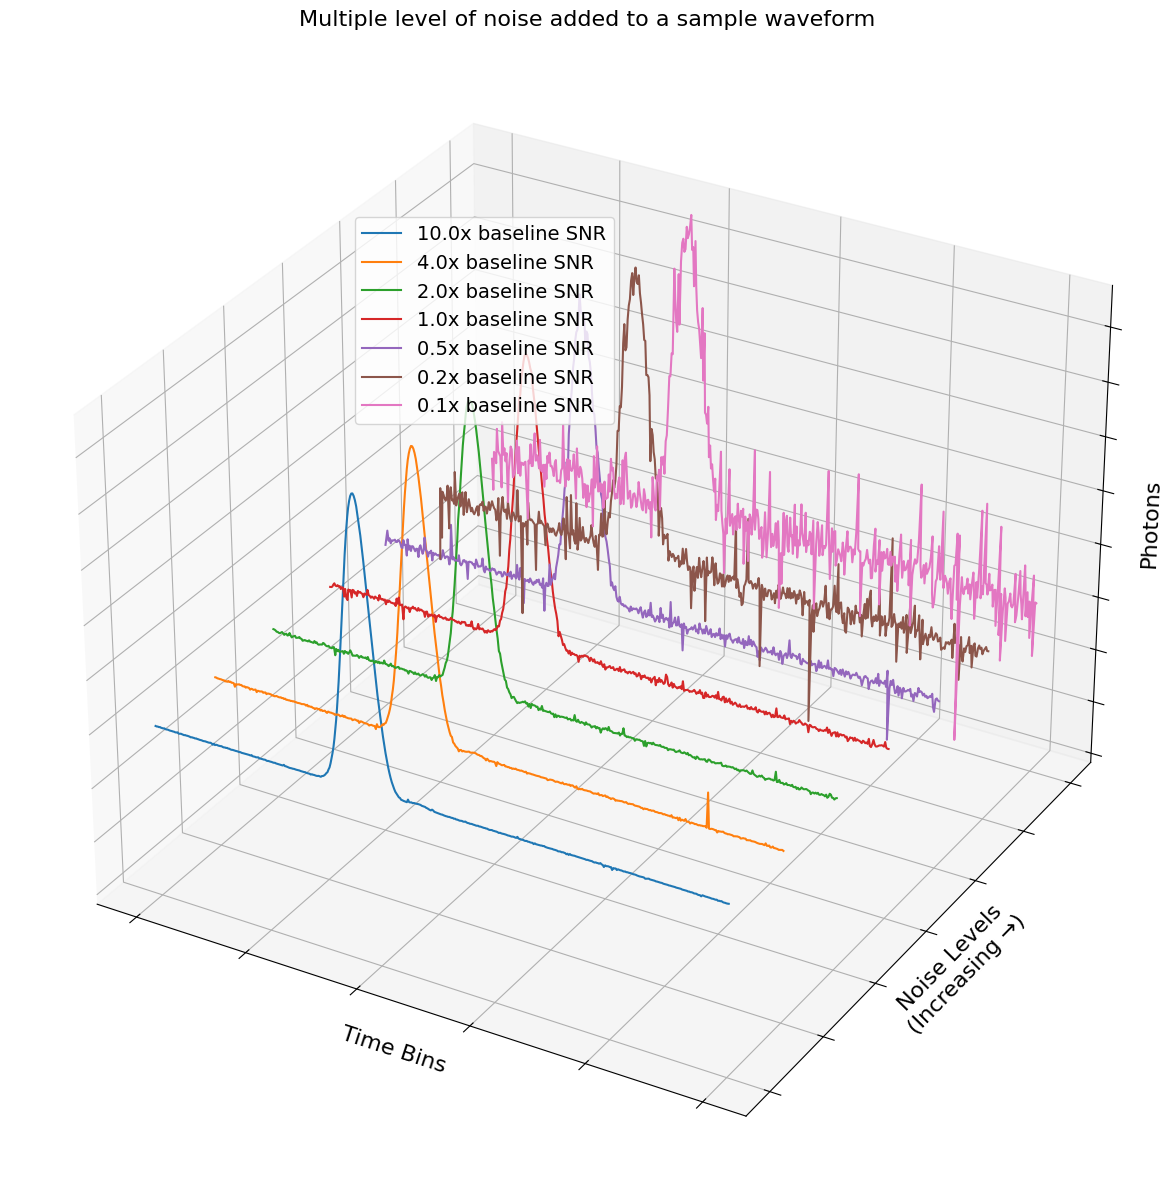

In [16]:
## 4. Adding noise to the waveforms

"""
    - We are adding noise to the simulated waveform based on the peak height distribution of simulated waveforms.
    - For each time bin in the simulated waveform we are choosing a random value from peak height distribution and scaling it with 
    - the random value choosen from peak height distribution of real data and then adding the random value from real waveform noise distribution.

        So for each time bin:

        Noise_sim = (Sim_peak_height / Real_peak_height) * Real_noise

        and the Noisy signal will be:

        Noisy_waveform = Simulated_waveform + Noise_sim

        This will maintain the SNR (approx.) between noise added simulated signal and real signal.

    - We also included a noise_level scaling factor so that we can tune the SNR levels added into simulated waveforms.

        So the final expression for noisy waveform for each time bin will be:

        Noisy_waveform = Simulated_waveform + N * Noise_sim

            here N = 1 corresponds to baseline SNR i.e. SNR corresponding to our real data
            higher value of N will decrease SNR by factor (1/N) and vice-versa.

            This is based on our definition of SNR: SNR = (peak_signal_height/Noise_std) 

"""

## Converting to code
# Noise levels and labels
noise_levels = [0.1, 0.25, 0.5, 1, 2, 5, 10]
noise_labels = [f'{1/i}x baseline SNR' for i in noise_levels]

# Sample only few profiles to process
num_samples = 10
profiles_subset = [f"profile_{i}.txt" for i in range(num_samples) ]

# Create a new dictionary that only contains the selected profiles
waveforms_df = {key: waveforms[key] for key in profiles_subset}

# Choose one waveform for visualization (e.g., profile_0.txt)
profile_key = 'profile_0.txt'
bins = waveforms_df[profile_key]['bins']  # Time bins
original_waveform = waveforms_df[profile_key]['intensity']  # Original waveform

# 2D array to store waveforms at all noise levels
waveforms_with_noise = []

for noise_level in noise_levels:
    # Initialize noisy waveform with a copy of the original
    noisy_waveform = original_waveform.copy()

    # Add noise to the waveform
    for i in range(len(bins)):

        # noise scaling logic
        real_peak_height = np.random.choice(signal_height_dist_real)
        simulated_peak_height = np.random.choice(signal_height_dist_sim_filtered)
        scale_factor = simulated_peak_height / real_peak_height if real_peak_height != 0 else 0
        noise = np.random.choice(noise_real)
        scaled_noise = noise * scale_factor * noise_level
        noisy_waveform[i] += scaled_noise

    # Store noisy waveform for this noise level
    waveforms_with_noise.append(noisy_waveform)

# Convert to a NumPy array for easier processing
waveforms_with_noise = np.array(waveforms_with_noise)

# Create a 3D plot
fig = plt.figure(figsize=(20, 15))
ax = fig.add_subplot(111, projection='3d')

# Plot each noisy waveform as a plane for different noise levels
for idx, noisy_waveform in enumerate(waveforms_with_noise):
    separation_factor = idx  # Adjust this to increase separation between plots
    ax.plot(
        bins,  # X-axis: time bins
        [separation_factor] * len(bins),  # Y-axis: constant index for this noise level with separation
        (noisy_waveform / cf),  # Z-axis: waveform intensity
        label=noise_labels[idx],linewidth=1.5
    )

# Set axis labels and title
ax.set_xlabel('Time Bins', labelpad=1)
ax.set_ylabel('Noise Levels\n(Increasing →)', labelpad=1)
ax.set_zlabel('Photons', labelpad=1)

# Remove y-axis values
ax.set_yticklabels([]) 
ax.tick_params(axis='y', which='both', length=0)  

# Remove x-axis values
ax.set_xticklabels([])
ax.tick_params(axis='x', which='both', length=0)  

# Remove z-axis values
ax.set_zticklabels([])  
ax.tick_params(axis='z', which='both', length=0)  
legend = ax.legend(loc='upper left', bbox_to_anchor=(0.29, 0.85), frameon=True)
plt.title("Multiple level of noise added to a sample waveform")
plt.show()
